In [2]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
set_log_level(30)

In [3]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

from matplotlib import animation

# Physically meaningful parameters

In [15]:
# parameters["ghost_mode"] = "shared_facet"

# compare upwind flux with lax-friedrichs flux
lx = 1
m_size = lx*50
mesh = IntervalMesh(m_size, 0.0, lx)

# Material properties
mu = Constant(14e9)
rho = Constant(2.2e3)
gamma = Constant(1)
tau = 10e-3*gamma # \tau_1 in the literature


beta_E = 50
delta_E = 1e8

delta_t = 2e-6
t_total = 80e-3

t_excitation = 40e-3

fc = 5e3

A_amp = 1e-6

deg_dg = 0 # DG degree

def mu_fun(eps):
    return mu * (1 - 2*beta_E*eps - 3 * delta_E*eps*eps)

def stress_fun(eps):
    return mu * eps * (1 - beta_E*eps - delta_E*eps*eps)

def energy_fun(eps):
    return mu * eps * eps * (0.5 - beta_E/3*eps  - delta_E/4*eps*eps)

A_amp1 = float(stress_fun(A_amp)/rho)

def flux_fun(q_f):
    (eps,vel, g_int) = split(q_f)
    return as_vector([-vel('+'), -(1-g_int('+'))*stress_fun(eps('+'))/rho ,0]) \
           + as_vector([-vel('-'), -(1-g_int('-'))*stress_fun(eps('-'))/rho ,0])

def AStar_fun(q_f):
    (eps, vel, g_int) = split(q_f)
    a = (1 - 0.5*(g_int('+')+g_int('-')) ) * mu_fun(eps('+'))/rho
    b = stress_fun(eps('+'))/rho
    RStar = as_tensor([[1, 1, b], \
                       [sqrt(a), -sqrt(a), 0], \
                       [0, 0, a]])
    RStar_inv = as_tensor([[1/2, 1/2/sqrt(a), -b/a/2], \
                           [1/2, -1/2/sqrt(a), -b/a/2], \
                           [0, 0, 1/a]])
    Lamb = as_tensor([[sqrt(a), 0, 0], \
                      [0, sqrt(a), 0], \
                      [0, 0, 0]])
    return dot(dot(RStar,Lamb),RStar_inv)

# Function space
Ee = FiniteElement("DG", mesh.ufl_cell(), deg_dg)
Ve = FiniteElement("DG", mesh.ufl_cell(), deg_dg)
Ge = FiniteElement("DG", mesh.ufl_cell(), deg_dg)
V_dg = FunctionSpace(mesh, MixedElement([Ee, Ve, Ge]))

phi, v = TrialFunction(V_dg), TestFunction(V_dg)
q_new, q_old = Function(V_dg), Function(V_dg)
q_rk = Function(V_dg)

q0 = Expression(("0","0","0"), degree=1, t=0, name='q0') # 
q_old = project(q0, V_dg)

v_exact = Expression("(t<tc1 ) ? A*(lx-x[0])/lx*sin(2*pi*(x[0] + c*t)) : 0 ", \
                     degree=1, t=0, tc1=t_excitation, c=fc, A=A_amp, lx = lx) # 

v_exact2 = Expression("(t<tc1 ) ? A*(lx-x[0])/lx*sin(2*pi*(x[0] + c*t)) : 0 ", \
                     degree=1, t=0, tc1=t_excitation, c=fc, A=A_amp1, lx = lx) # 

v_exactr = Expression(" 0 ", \
                     degree=1, t=0, tc1=t_excitation, c=fc, A=A_amp, lx = lx) # 

f_ext = Expression(("0", "(t<tc1 ) ? -A*(lx-x[0])/lx*sin(2*pi*(x[0] + c*t)) : 0 ", "0"), \
                   degree=1, t=0, tc1=t_excitation, c=fc, A=A_amp1, lx = lx) #

DOFIN_EPS = 1e-10 # + 1/40
def left(x, on_boundary):
    return abs(x[0]-0.) < DOFIN_EPS
def right(x, on_boundary):
    return abs(x[0]-lx) < DOFIN_EPS


bc =  [DirichletBC(V_dg.sub(0), v_exact, left, method="pointwise"),\
       DirichletBC(V_dg.sub(0), v_exactr, right, method="pointwise"),\
       DirichletBC(V_dg.sub(1), v_exactr, right, method="pointwise"),\
       DirichletBC(V_dg.sub(2), v_exactr, right, method="pointwise")]

# Weak form
n = FacetNormal(mesh)

(eps1,vel1, g_int1) = split(q_old)
mu1 = mu_fun(eps1)
sig1 = stress_fun(eps1)

c_speed1 = sqrt((1-g_int1)*mu1/rho)

W_energy1 = energy_fun(eps1)

A_adv1 = as_tensor([[0, -1, 0], \
                    [-(1-g_int1)*mu1/rho, 0, sig1/rho], \
                    [0, 0, 0]])

R1 = as_tensor([[1, 1, sig1/rho], \
                [c_speed1, -c_speed1, 0], \
                [0,0,c_speed1*c_speed1]])
R_inv1 = as_tensor([[1/2, 1/c_speed1/2, -sig1/rho/c_speed1/c_speed1/2], \
                    [1/2, -1/c_speed1/2, -sig1/rho/c_speed1/c_speed1/2], \
                    [0, 0, 1/c_speed1/c_speed1] ])
Lambda_adv_abs1 = as_tensor([[c_speed1, 0, 0], \
                             [0, c_speed1, 0], \
                             [0, 0, 0] ])

A_adv_abs1 = dot( dot(R1, Lambda_adv_abs1), R_inv1)

A_adv_plus1 = (A_adv1 + A_adv_abs1)/2
A_adv_minus1 = (A_adv1 - A_adv_abs1)/2

F = dot( (phi-q_old)/delta_t, v) * dx 

flux_inner1 = as_vector([-vel1, -(1-g_int1)*sig1/rho, 0])
# F1 = F - dot(dot(A_adv1,q_old), grad(v)[:,0]) * dx
F1 = F - dot(flux_inner1, grad(v)[:,0]) * dx

r1 = as_vector([0, 0, 1/tau*(W_energy1 - gamma*g_int1/(1-g_int1*g_int1))])
F1 += - dot(r1, v) * dx

flux1 = dot(A_adv_plus1('+'), q_old('+')) + dot(A_adv_minus1('-'), q_old('-'))

# Roe solver
flux1 = 0.5*( flux_fun(q_old) \
             - dot( AStar_fun(q_old), q_old('-')-q_old('+')  ) ) 

F1 += dot( flux1*n('+')[0], jump(v)) * dS + dot(f_ext,v)*n[0] * ds

(eps2,vel2, g_int2) = split(q_rk)
mu2 = mu_fun(eps2)
sig2 = stress_fun(eps2)

c_speed2 = sqrt((1-g_int2)*mu2/rho)

W_energy2 = energy_fun(eps2)

A_adv2 = as_tensor([[0, -1, 0], \
                    [-(1-g_int2)*mu2/rho, 0, sig2/rho], \
                    [0, 0, 0]])

R2 = as_tensor([[1, 1, sig2/rho], \
                [c_speed2, -c_speed2, 0], \
                [0,0,c_speed2*c_speed2]])
R_inv2 = as_tensor([[1/2, 1/c_speed2/2, -sig2/rho/c_speed2/c_speed2/2], \
                    [1/2, -1/c_speed2/2, -sig2/rho/c_speed2/c_speed2/2], \
                    [0, 0, 1/c_speed2/c_speed2] ])
Lambda_adv_abs2 = as_tensor([[c_speed2, 0, 0], \
                             [0, c_speed2, 0], \
                             [0, 0, 0] ])

A_adv_abs2 = dot( dot(R2, Lambda_adv_abs2), R_inv2)

A_adv_plus2 = (A_adv2 + A_adv_abs2)/2
A_adv_minus2 = (A_adv2 - A_adv_abs2)/2

flux_inner2 = as_vector([-vel2, -(1-g_int2)*sig2/rho, 0])
# F2 = - dot(dot(A_adv2,q_rk), grad(v)[:,0]) * dx
F2 = - dot(flux_inner2, grad(v)[:,0]) * dx

r2 = as_vector([0, 0, 1/tau*(W_energy2 - gamma*g_int2/(1-g_int2*g_int2))])

F2 += - dot(r2, v) * dx

flux2 = dot(A_adv_plus2('+'), q_rk('+')) + dot(A_adv_minus2('-'), q_rk('-'))

# Roe solver
flux2 = 0.5*( flux_fun(q_rk) \
            - dot( AStar_fun(q_rk), q_rk('-')-q_rk('+')  ) ) 

F2 += dot( flux2*n('+')[0], jump(v)) * dS + dot(f_ext,v)*n[0] * ds

F += 0.5*((F1-F) + F2)

t = 0
time_steps = int(t_total/delta_t)
uu1 = np.zeros((time_steps,m_size,3))
for n in range(time_steps):
    print('===============')
    print('Time step:',n)
    
    for i in range(m_size):
        uu1[n,i,:] = q_old(i/(m_size-1)*lx)[:]
    
    a,L = lhs(F1),rhs(F1)
    solve(a==L, q_new, bc)
    q_rk.assign(q_new)
        
    a,L = lhs(F),rhs(F)
    solve(a==L, q_new, bc)
    q_old.assign(q_new)
    print('Strain:',q_old(0)[0])

    t += delta_t
    v_exact.t = t
    f_ext.t = t
    
plt.subplots()
plot(q_old[2])
plt.show()

Time step: 0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Strain: 0.0
Time step: 1
Strain: -1.5980643878534104e-08
Time step: 2
Strain: -5.5725200025441484e-08
Time step: 3
Strain: -1.2300024835745516e-07
Time step: 4
Strain: -2.195022053265122e-07
Time step: 5
Strain: -3.4583166055262e-07
Time step: 6
Strain: -5.019819041050805e-07
Time step: 7
Strain: -6.875848371686843e-07
Time step: 8
Strain: -9.020358487688023e-07
Time step: 9
Strain: -1.144558425362244e-06
Time step: 10
Strain: -1.4142388458362629e-06
Time step: 11
Strain: -1.7100461039009891e-06
Time step: 12
Strain: -2.030844593168146e-06
Time step: 13
Strain: -2.3754032869802005e-06
Time step: 14
Strain: -2.742403244792779e-06
Time step: 15
Strain: -3.1304443291541163e-06
Time step: 16
Strain: -3.538051546642058e-06
Time step: 17
Strain: -3.963681194611791e-06
Time step: 18
Strain: -4.40572688414811e-06
Time step: 19
Strain: -4.8625254584752

Strain: -1.1437136121623599e-05
Time step: 133
Strain: -1.1912830101704107e-05
Time step: 134
Strain: -1.2375166837416565e-05
Time step: 135
Strain: -1.282229327209634e-05
Time step: 136
Strain: -1.3252393426979637e-05
Time step: 137
Strain: -1.366369550681125e-05
Time step: 138
Strain: -1.4054479440141326e-05
Time step: 139
Strain: -1.4423084860706065e-05
Time step: 140
Strain: -1.476791951691884e-05
Time step: 141
Strain: -1.5087468073766595e-05
Time step: 142
Strain: -1.5380301245754465e-05
Time step: 143
Strain: -1.564508517173813e-05
Time step: 144
Strain: -1.5880590913653706e-05
Time step: 145
Strain: -1.608570393277913e-05
Time step: 146
Strain: -1.6259433371029395e-05
Time step: 147
Strain: -1.6400920942907643e-05
Time step: 148
Strain: -1.6509449228182587e-05
Time step: 149
Strain: -1.658444914809576e-05
Time step: 150
Strain: -1.662550641053414e-05
Time step: 151
Strain: -1.6632366723179926e-05
Time step: 152
Strain: -1.660493959845145e-05
Time step: 153
Strain: -1.6543300609

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


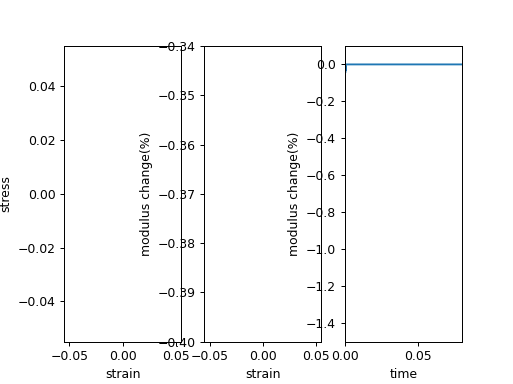

In [22]:
uu = uu1

x_ind = 5

u_sig = float(mu)*uu[:, x_ind,0] * (1-uu[:, x_ind,2]) \
* (1 - float(beta_E)*uu[:, x_ind,0] - float(delta_E)*uu[:, x_ind,0]*uu[:, x_ind,0])
u_modulus = float(mu) * (1-uu[:, x_ind,2]) \
* (1 - 2 * float(beta_E)*uu[:, x_ind,0] - 3 * float(delta_E)*uu[:, x_ind,0]*uu[:, x_ind,0])

t_sta = 19850
t_end = 19950

plt.subplots()
plt.subplot(1,3,1)
plt.plot(uu[t_sta:t_end, x_ind,0],u_sig[t_sta:t_end])
plt.xlabel('strain')
plt.ylabel('stress')
plt.subplot(1,3,2)
plt.plot(uu[t_sta:t_end, x_ind,0],(u_modulus[t_sta:t_end]-float(mu))/float(mu)*100)
plt.xlabel('strain')
plt.ylabel('modulus change(%)')
plt.ylim([-0.4,-0.34])
plt.subplot(1,3,3)
plt.plot(np.linspace(0,t_total,time_steps), (u_modulus-float(mu))/float(mu)*100)
plt.ylim([-1.5,0.1])
# plt.semilogy(np.linspace(0,t_total,time_steps), uu[:, 0,2])
plt.xlim([0.,0.08])
plt.xlabel('time')
plt.ylabel('modulus change(%)')

# plt.ylim([0.,0.3])
plt.show()

<IPython.core.display.Javascript object>


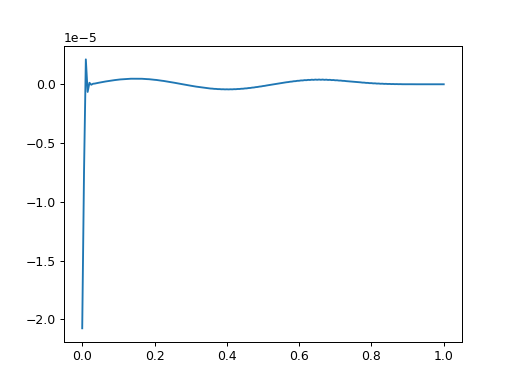

0.00031199999999999934

In [16]:


plt.subplots()
plot(q_old[0])

t

# Roe solver

<IPython.core.display.Javascript object>


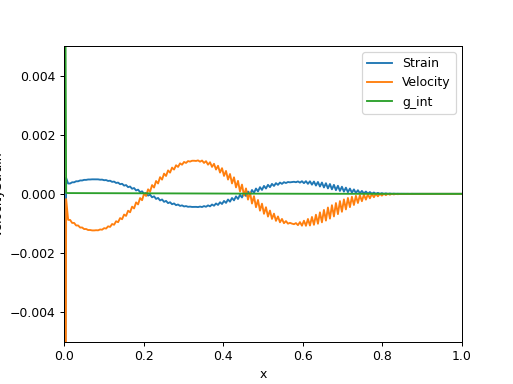

In [17]:
fig, ax = plt.subplots()

line1, = ax.plot([],'-')
line2, = ax.plot([],'-')
line3, = ax.plot([],'-')

ax.set_xlim(0,1)
ax.set_ylim(-0.5e-7,0.5e-7)
# ax.set_ylim(-1e-0,2e-0)
ax.set_ylim(-5e-3,5e-3)

ax.set_xlabel('x')
ax.set_ylabel('VelocityStrain')
ax.legend(['Strain','Velocity','g_int'])

N_d = 1

Nincr = 10000 # Time steps

N_x = 1

def animate(frame_num):
    # ax.clear()
    line1.set_data((np.linspace(0,lx,int(m_size/N_x)), 1e3*uu1[frame_num*N_d, 0:m_size:N_x,0])) #
    line2.set_data((np.linspace(0,lx,int(m_size/N_x)), 1e0*uu1[frame_num*N_d, 0:m_size:N_x,1])) #
    line3.set_data((np.linspace(0,lx,int(m_size/N_x)), 1e0*uu1[frame_num*N_d, 0:m_size:N_x,2])) #
    # line2.set_data((np.linspace(0,1,100), u_up_d[frame_num*N_d, :,1]))
    # line3.set_data((np.linspace(0,10,N_mesh), results_1d2[frame_num, :]-0.1)) # Implicit - manual
    return line1, line2, line3

ani = FuncAnimation(fig, animate, frames=int(Nincr/N_d), interval=100)

plt.show()